In [2]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gprofiler import GProfiler

In [3]:
# Initialize gProfiler
gp = GProfiler(return_dataframe=True)
organism_id = 'mmusculus'

In [4]:
#Load the data with all DE results already computed
adata = sc.read_h5ad('condition_DE_analysis.h5ad')
am_cells = sc.read_h5ad('am_cells_DE.h5ad')
im_cells = sc.read_h5ad('im_cells_DE.h5ad')
infected_cells = sc.read_h5ad('infected_cells_DE.h5ad')

In [5]:
print("Available keys:", [k for k in adata.uns.keys() if 'rank' in k or 'vs' in k])

Available keys: ['infected_vs_control']


In [6]:
# Extract top genes from each DE comparison
def get_top_genes(adata_obj, key, group, n_genes=20):
    """Extract top DE genes from scanpy results"""
    if key in adata_obj.uns:
        genes = adata_obj.uns[key]['names'][group][:n_genes].tolist()
        return [g for g in genes if pd.notna(g)]
    else:
        print(f"Key {key} not found")
        return []

In [13]:
# 1. Overall infection response genes
infection_genes = get_top_genes(adata, 'infected_vs_control', 'Infected', 20)
print(f"Infection genes (n={len(infection_genes)}): {infection_genes}")

Infection genes (n=20): ['Gbp2', 'Gbp7', 'Stat1', 'Nampt', 'Wfdc17', 'Gbp5', 'Parp14', 'Ctsc', 'AW112010', 'Ms4a6d', 'Lilrb4a', 'Ifih1', 'Cfb', 'Ifi47', 'AY036118', 'Rnf213', 'Tgfbi', 'Fbxl5', 'Oasl2', 'Slfn2']


In [14]:
# 2. AM-specific infection response
am_infection_genes = get_top_genes(am_cells, 'am_infected_vs_control', 'Infected', 20)
print(f"AM infection genes (n={len(am_infection_genes)}): {am_infection_genes}")

AM infection genes (n=20): ['mt-Nd4l', 'Plek', 'AY036118', 'Macf1', 'Ptprc', 'Wfdc17', 'Fbxl5', 'Gm21092', 'mt-Nd6', 'March1', 'Vps13c', 'mt-Nd5', 'Ifih1', 'Gm10076', 'Parp14', 'Usp9x', 'AI607873', 'Gbp2', 'Irf1', 'Ifi204']


In [15]:
# 3. IM-specific infection response
im_infection_genes = get_top_genes(im_cells, 'im_infected_vs_control', 'Infected', 20)
print(f"IM infection genes (n={len(im_infection_genes)}): {im_infection_genes}")

IM infection genes (n=20): ['Stat1', 'Gbp2', 'Oasl2', 'Gbp7', 'Gbp5', 'Parp14', 'Ms4a6d', 'Ifi47', 'Rnf213', 'Tap1', 'Trim30a', 'Isg15', 'Ifi204', 'Nampt', 'Slfn1', 'Slfn2', 'Cd300lf', 'Pydc4', 'Gbp3', 'Mndal']


In [17]:
# 4. M(Kp) signature - bacterial+ vs bystander (MOST IMPORTANT)
mkp_genes = get_top_genes(infected_cells, 'bacterial_vs_bystander', 'KP+', 20)
print(f"M(Kp) signature genes (n={len(mkp_genes)}): {mkp_genes}")

M(Kp) signature genes (n=20): ['Fth1', 'Gm10076', 'Lgals3', 'Cxcl2', 'Cxcl3', 'Txn1', 'Cstb', 'Capg', 'AA467197', 'Ftl1', 'Il1a', 'Fabp5', 'S100a9', 'Prdx1', 'Slpi', 'S100a8', 'Atp6v1g1', 'Cd63', 'Gabarap', 'Il1rn']


In [18]:
# Run gProfiler pathway analysis on each gene set
all_pathway_results = {}
# 1. Overall infection response
print("=== Analyzing infection response pathways ===")
infection_pathways = gp.profile(
    organism=organism_id,
    query=infection_genes,
    sources=['GO:BP', 'KEGG', 'REAC'],
    user_threshold=0.05
)

all_pathway_results['infection'] = infection_pathways
print(f"Found {len(infection_pathways)} significant pathways")
# 2. M(Kp) signature - MOST IMPORTANT
print("\n=== Analyzing M(Kp) signature pathways ===")
mkp_pathways = gp.profile(
    organism=organism_id,
    query=mkp_genes,
    sources=['GO:BP', 'KEGG', 'REAC'],
    user_threshold=0.05
)

all_pathway_results['mkp'] = mkp_pathways
print(f"Found {len(mkp_pathways)} significant pathways")
# Display top results
print("\n=== Top M(Kp) pathways ===")
if not mkp_pathways.empty:
    print(mkp_pathways[['name', 'p_value', 'source']].head(10))
else:
    print("No significant pathways found")

=== Analyzing infection response pathways ===
Found 57 significant pathways

=== Analyzing M(Kp) signature pathways ===
Found 59 significant pathways

=== Top M(Kp) pathways ===
                             name       p_value source
0            neutrophil migration  6.941538e-08  GO:BP
1           granulocyte migration  4.222660e-07  GO:BP
2           neutrophil chemotaxis  2.735571e-06  GO:BP
3     myeloid leukocyte migration  5.272177e-06  GO:BP
4          granulocyte chemotaxis  1.503244e-05  GO:BP
5             leukocyte migration  1.212562e-04  GO:BP
6            Rheumatoid arthritis  2.721573e-04   KEGG
7            leukocyte chemotaxis  3.103267e-04  GO:BP
8  response to lipopolysaccharide  3.400133e-04  GO:BP
9         IL-17 signaling pathway  3.553337e-04   KEGG


In [28]:
# Look for STAT6 and immune pathways specifically
print("=== Searching for STAT6 and key immune pathways ===")
def search_pathways(df, search_terms):
    """Search pathway results for specific terms"""
    if df.empty:
        return pd.DataFrame()
    mask = df['name'].str.contains('|'.join(search_terms), case=False, na=False)
    return df[mask][['name', 'p_value', 'source', 'intersection_size']]
            
# Search M(Kp) pathways for key terms
stat6_terms = ['STAT6', 'IL-4', 'IL-13', 'Th2', 'alternative activation']
immune_terms = ['immune', 'antimicrobial', 'bacterial', 'pathogen', 'defense']
interferon_terms = ['interferon', 'antiviral', 'IFN']
print("STAT6-related pathways in M(Kp):")
stat6_results = search_pathways(mkp_pathways, stat6_terms)
print(stat6_results if not stat6_results.empty else "None found")
print("\nImmune/antimicrobial pathways in M(Kp):")
immune_results = search_pathways(mkp_pathways, immune_terms)
print(immune_results.head() if not immune_results.empty else "None found")
      
# Compare to general infection pathways
print("\nInterferon pathways in general infection:")
ifn_results = search_pathways(infection_pathways, interferon_terms)
print(ifn_results.head() if not ifn_results.empty else "None found")

=== Searching for STAT6 and key immune pathways ===
STAT6-related pathways in M(Kp):
None found

Immune/antimicrobial pathways in M(Kp):
                                        name   p_value source  \
11  response to molecule of bacterial origin  0.000424  GO:BP   
17                           immune response  0.001625  GO:BP   
18                      Innate Immune System  0.001715   REAC   
19                             Immune System  0.001758   REAC   
24            antimicrobial humoral response  0.002861  GO:BP   

    intersection_size  
11                  6  
17                  9  
18                  9  
19                 11  
24                  4  

Interferon pathways in general infection:
                                       name   p_value source  \
12  cellular response to type II interferon  0.000003  GO:BP   
14           response to type II interferon  0.000010  GO:BP   
16     cellular response to interferon-beta  0.000022  GO:BP   
17              response to i

### While none of our MKP signatures relate to STAT6 pathways and cannot directly support the paper's finding yet, the signatures and pathways illustrate the macrophage's pathways at play during acute bacterial response:

  The findings are still valuable:
  - Confirm bacterial+ cells are biologically distinct ✓
  - Show clear antimicrobial response ✓
  - Validate infection model works ✓
  - Identify key inflammatory pathways ✓

  What has been found so far:
  - Classical antimicrobial macrophage response
  - Neutrophil recruitment pathways
  - Iron sequestration (nutritional immunity)
  - This is good biology even if different from their STAT6 story

### Its possible that the STAT6-related pathway signatures lie in a subcluster of our condition groups:


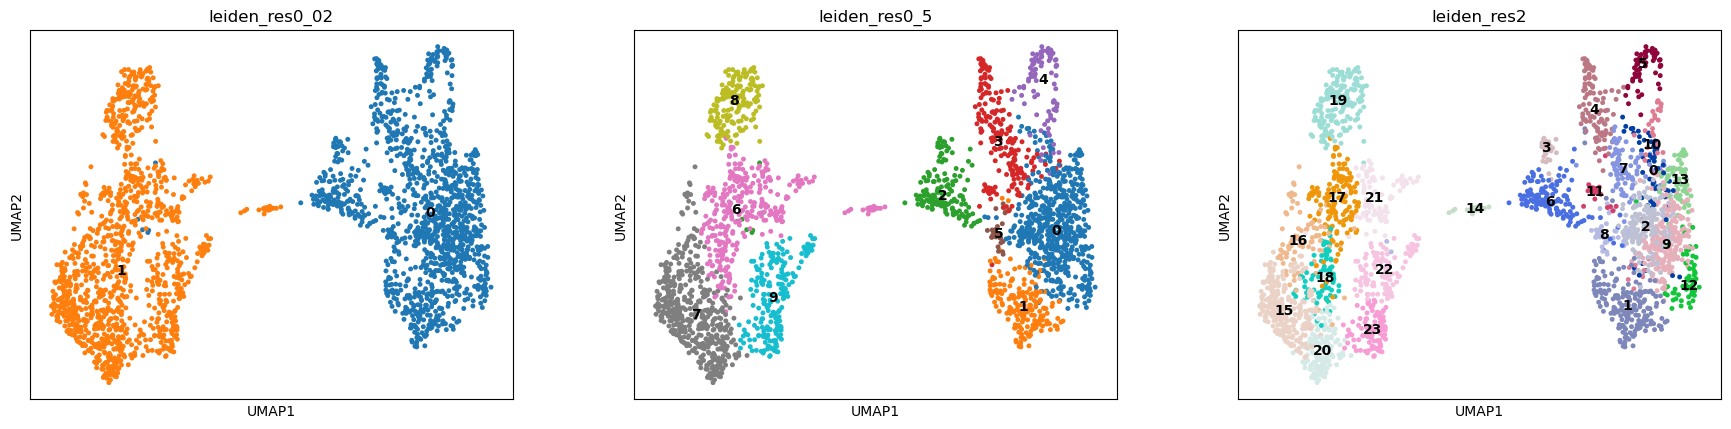

In [33]:
sc.tl.leiden(adata, flavor="igraph", key_added="leiden_res0_02", resolution=0.02)
sc.tl.leiden(adata, flavor="igraph", key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, flavor="igraph", key_added="leiden_res2", resolution=2)

sc.pl.umap(
    adata,
    color=["leiden_res0_02", "leiden_res0_5", "leiden_res2"],
    legend_loc="on data",
)